# Comparing by critical lifetime ratio (PHASOR part)
Simulating the lifetime decay from 3.07 to 2.5, for 20 points. Amplitude the same as before. Derive the index of separability to obtain critical
lifetime ratio.

In [18]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import convolve
from scipy import stats
from sympy import symbols, solve, Eq, Function, nsolve
from sympy.matrices import Matrix
import sympy as sp
from scipy.optimize import curve_fit
from lmfit import Model, Parameters
import lmfit
import inspect
import pandas as pd
import numdifftools
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import fsolve
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True
plt.style.use('seaborn-v0_8-deep')

In [210]:
#colors
import numpy as np
import matplotlib.pyplot as plt

def generate_colors(n):
    colors = []
    n1 = n // 4
    n2 = n // 4
    n3 = n // 4
    n4 = n - n1 - n2 - n3 
    for i in range(n1):
        fraction = i / (n1 - 1) if n1 > 1 else 1
        colors.append((0, 0, 0.5 + fraction * 0.5))
    
    for i in range(n2):
        fraction = i / (n2 - 1) if n2 > 1 else 1
        colors.append((0, fraction, 1 - fraction))
    
    for i in range(n3):
        fraction = i / (n3 - 1) if n3 > 1 else 1
        colors.append((0, 0.5 + fraction * 0.5, 0))
    
    for i in range(n4):
        fraction = i / (n4 - 1) if n4 > 1 else 1
        colors.append((fraction, 1, 0))
    
    return colors

colors = generate_colors(20)

In [124]:
# define functions from phasor.ipynb
def phasor_eq_func_A_vary(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1,A2, tau1, tau2)
       Input: 
       A_tau_arr    parameter array A1,A2 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int(len(A_tau_arr)/2) #number of components
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n]) for j in range(n)]) #pure multiexponential
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    A_sum = 1-np.sum(A_tau_arr[:n]) #A1,...An sum to 1
    phasor_compare = phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    return [A_sum]+list(phasor_compare) #

def phasor_eq_func(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    return phasor_test.real[:2*n-1]-phasor.real[:2*n-1] #solve for A_tau_arr such that it gives 0
    

def phasor_solve_num(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func,x0=x0,args = phasor)

In [125]:
# simulation for different lifetimes
tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.5,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num(phasor,[EGFP.amp[0],*EGFP.tau])

In [126]:
# calculate means and standard deviations
mean = np.mean(par_arr,axis = 1)
std = np.std(par_arr,axis = 1)

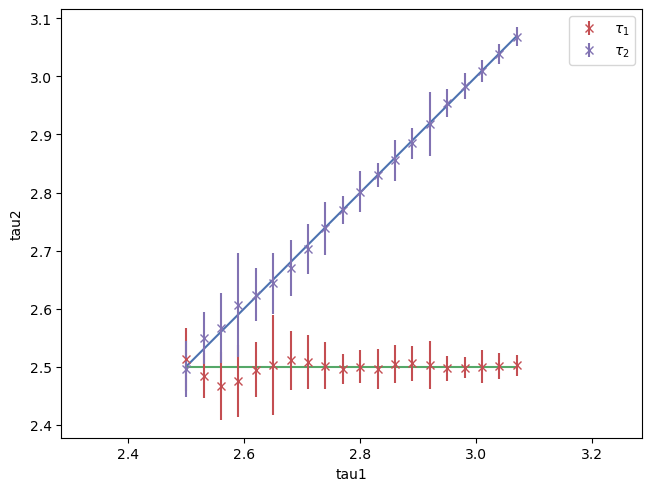

In [127]:
# plot 1D graph for simulated data
plt.figure()
plt.axis("equal")
plt.plot(tau_array,tau_array)
plt.plot([2.5,3.07],[2.5,2.5])
plt.errorbar(tau_array,mean[:,1],yerr=std[:,1],fmt = 'x',label=rf'$\tau_{1}$')
plt.errorbar(tau_array,mean[:,2],yerr=std[:,2],fmt = 'x',label=rf'$\tau_{2}$')

plt.xlabel("tau1")
plt.ylabel("tau2")
plt.legend()
plt.show()

## Simulation for lifetimes

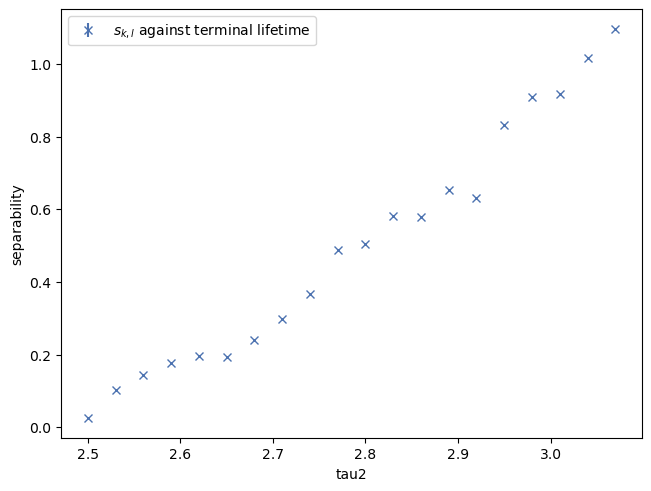

In [137]:
# calculate separability and plot it against lifetime
separability_0 = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

plt.figure()
plt.errorbar(tau_array,separability_0,yerr=0,fmt = '-.',label="$s_{k,l}$ against terminal lifetime")

plt.xlabel("tau2")
plt.ylabel("separability")
plt.legend()
plt.show()

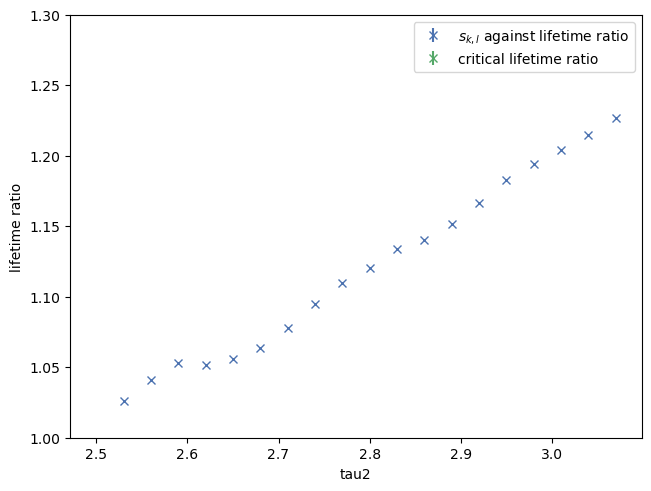

In [134]:
# plot lifetime ratio
critical_tau_ratio_0 = np.zeros(20)
if separability_0[i] < 1: 
    critical_tau_ratio_0[i] = 0
else:
    critical_tau_ratio_0[i] = mean[:,2]/mean[:,1]
plt.figure()
plt.ylim(1,1.3)
plt.errorbar(tau_array,mean[:,2]/mean[:,1],yerr=0,fmt = '--',label="$s_{k,l}$ against lifetime ratio")
plt.errorbar(tau_array,critical_tau_ratio_0,yerr=0,fmt = 'x',label="critical lifetime ratio")
plt.plot()

plt.xlabel("tau2")
plt.ylabel("lifetime ratio")
plt.legend()
plt.show()

In [8]:
# give the separabilitis and the critical lifetime where the lifetimes start to be separable
s_min = 0
for i in range(20):
    if separability_kl[i] < 1: 
        print("separability_kl is ", separability_kl[i], ", it's first nonseparatable pair of liftimes.")
    else:
        s_min = i
        print("separability_kl is ", separability_kl[i])
        print(f"The lifetimes are separable from the {i+1}th data. ")
        print(f"Thus, the critical lifetime ratio is {mean[i,2]/mean[i,1]}")
        break        

separability_kl is  0.029846753139106116 , it's first nonseparatable pair of liftimes.
separability_kl is  0.11252907683201059 , it's first nonseparatable pair of liftimes.
separability_kl is  0.150705280007619 , it's first nonseparatable pair of liftimes.
separability_kl is  0.16531922918771613 , it's first nonseparatable pair of liftimes.
separability_kl is  0.15139637241515652 , it's first nonseparatable pair of liftimes.
separability_kl is  0.17768654030117448 , it's first nonseparatable pair of liftimes.
separability_kl is  0.24237559451549934 , it's first nonseparatable pair of liftimes.
separability_kl is  0.25694237947105014 , it's first nonseparatable pair of liftimes.
separability_kl is  0.3407033214954039 , it's first nonseparatable pair of liftimes.
separability_kl is  0.4859191792258367 , it's first nonseparatable pair of liftimes.
separability_kl is  0.48238447046606564 , it's first nonseparatable pair of liftimes.
separability_kl is  0.5635926612522472 , it's first nonse

## Comparing performance with different angular frequency

In [249]:
# discuss the behavior of phasor_solve_num for different angular frequency
def phasor_eq_func_w(A_tau_arr,phasor,sec_i):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved
       x            the initial angular frequency'''
    n = int((len(A_tau_arr)+1)/2) #number of components
    #A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
    y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_compare = phasor_test.real[sec_i:2*n-1+sec_i]-phasor.real[sec_i:2*n-1+sec_i] #solve for A_tau_arr such that it gives 0
    return phasor_compare

def phasor_solve_num_w(phasor,x0,sec_i):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func_w,x0=x0,args=(phasor,sec_i))

def plot_w(x):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5

    # give the separabilitis and the critical lifetime where the lifetimes start to be separable
    s_min = 0
    critical_tau_ratio = 0
    for i in range(20):
        if separability_kl[i] < 1: 
            pass      
        else:
            s_min = i
            critical_tau_ratio = mean[i,2]/mean[i,1]
            print("separability_kl is ", separability_kl[i], ", it's first nonseparatable pair of liftimes.")
            print(f"The lifetimes are separable from the {i+1}th data. ")
            print(f"Thus, the critical lifetime ratio is {critical_tau_ratio}")
            break        

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"for angular frequency from {INDEX_i}", fontsize=16)
    axs[0].set_ylim(0,10)
    axs[1].set_ylim(0,2)
    axs[1].set_xlim(1,2)

    axs[0].plot(tau_array, tau_array)
    axs[0].plot([2.5, 3.07], [2.5, 2.5])
    axs[0].errorbar(tau_array, mean[:,1], yerr=std[:,1], fmt='x', label=rf'$\tau_{{1}}$')
    axs[0].errorbar(tau_array, mean[:,2], yerr=std[:,2], fmt='x', label=rf'$\tau_{{2}}$')
    axs[0].set_xlabel("initial lifetime")
    axs[0].set_ylabel("terminal lifetime")
    axs[0].legend()
    
    axs[1].errorbar(mean[:,2] / mean[:,1], separability_kl, yerr=0, fmt='x', label="$s_{k,l}$ against lifetime ratio")
    axs[1].set_xlabel("lifetime ratio")
    axs[1].set_ylabel("separability")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    return INDEX_i, separability_kl[s_min], critical_tau_ratio

In [29]:
INDEX_arr = np.zeros(20)
separation_arr = np.zeros(20)
critical_tau_arr = np.zeros(20)

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component


separability_kl is  1.0981441345509906 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 20th data. 
Thus, the critical lifetime ratio is 1.2260341067416423


C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:71: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


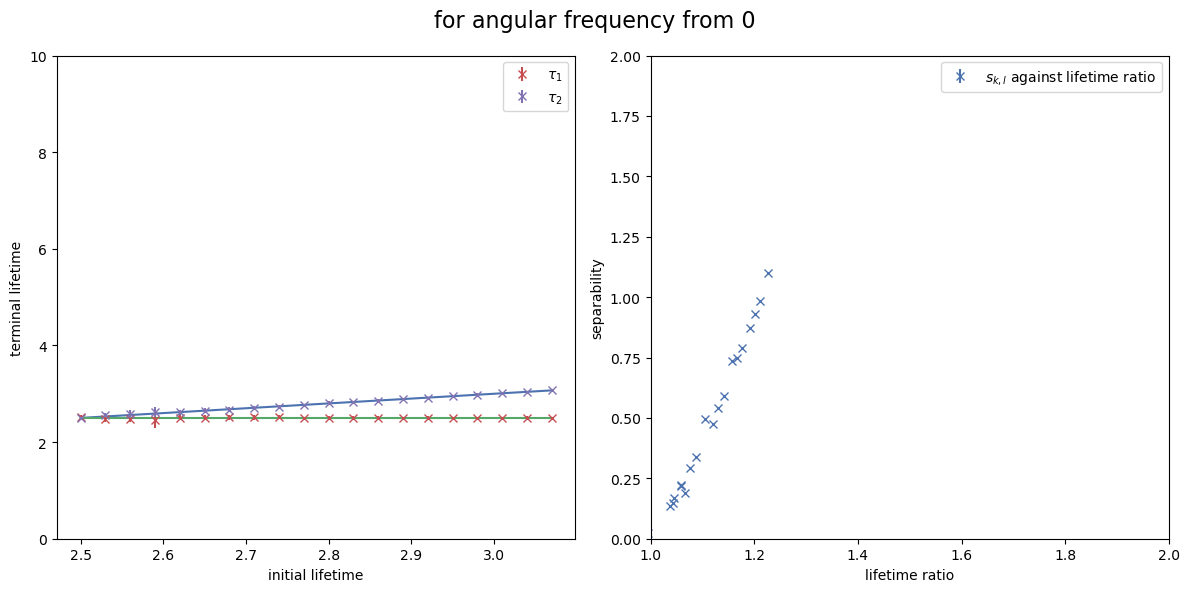

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


separability_kl is  14.879312946113165 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 5th data. 
Thus, the critical lifetime ratio is 35.137582959461


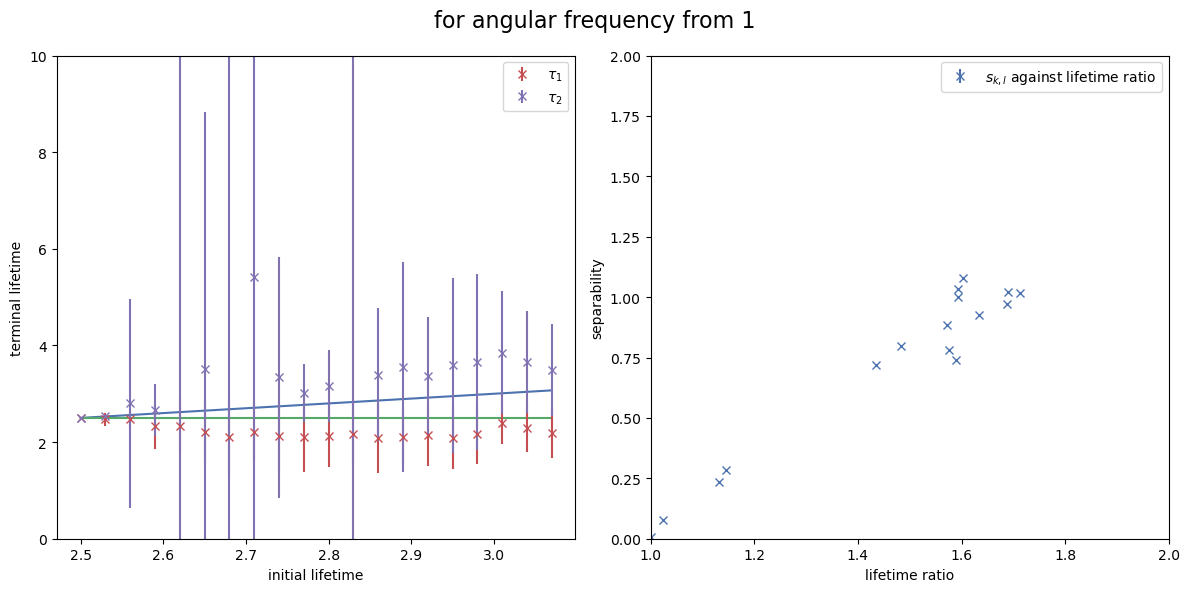

separability_kl is  1.810393085073807 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 13th data. 
Thus, the critical lifetime ratio is 3.018158629081265


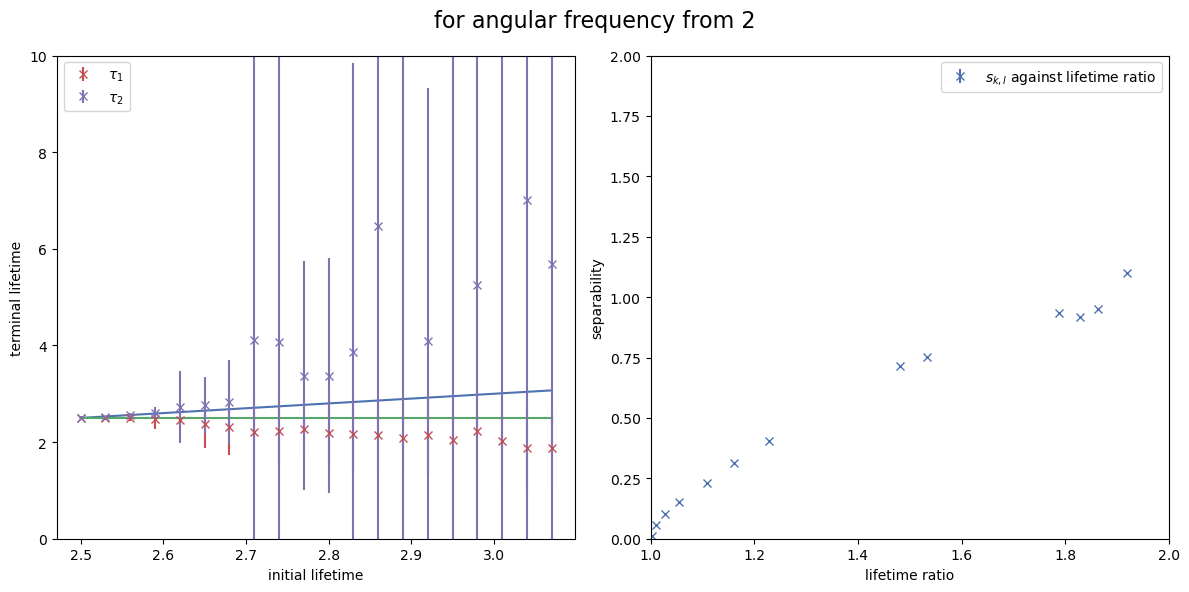

C:\Users\xujia\anaconda3\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


separability_kl is  1.068316384173308 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 18th data. 
Thus, the critical lifetime ratio is 1.734767155313588


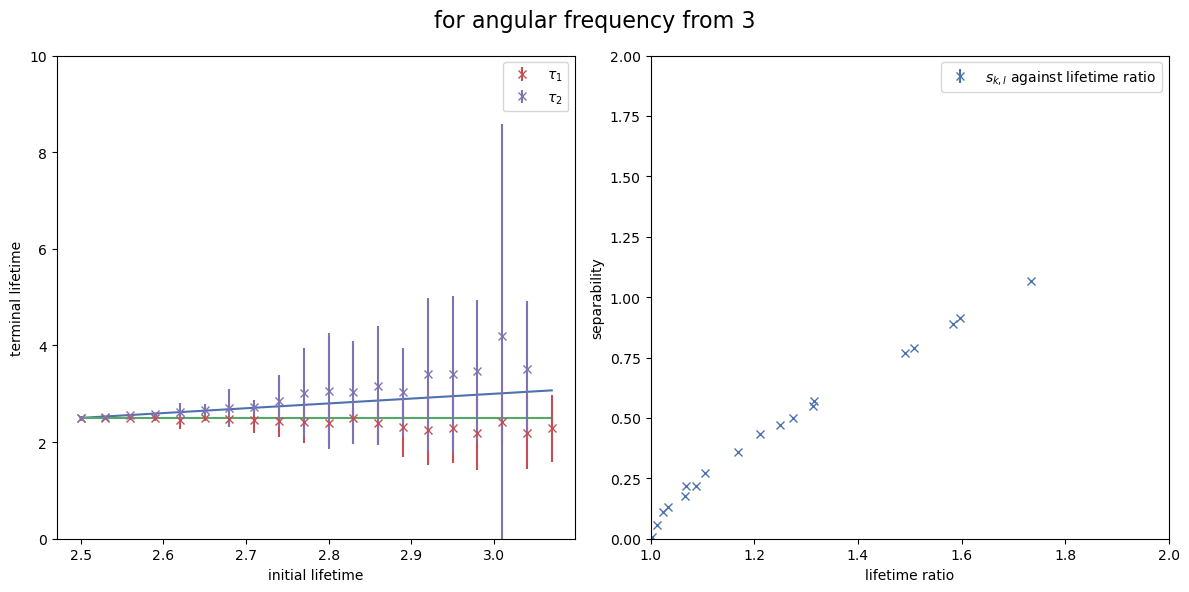

separability_kl is  1.1346765898465692 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 18th data. 
Thus, the critical lifetime ratio is 1.7358684261075674


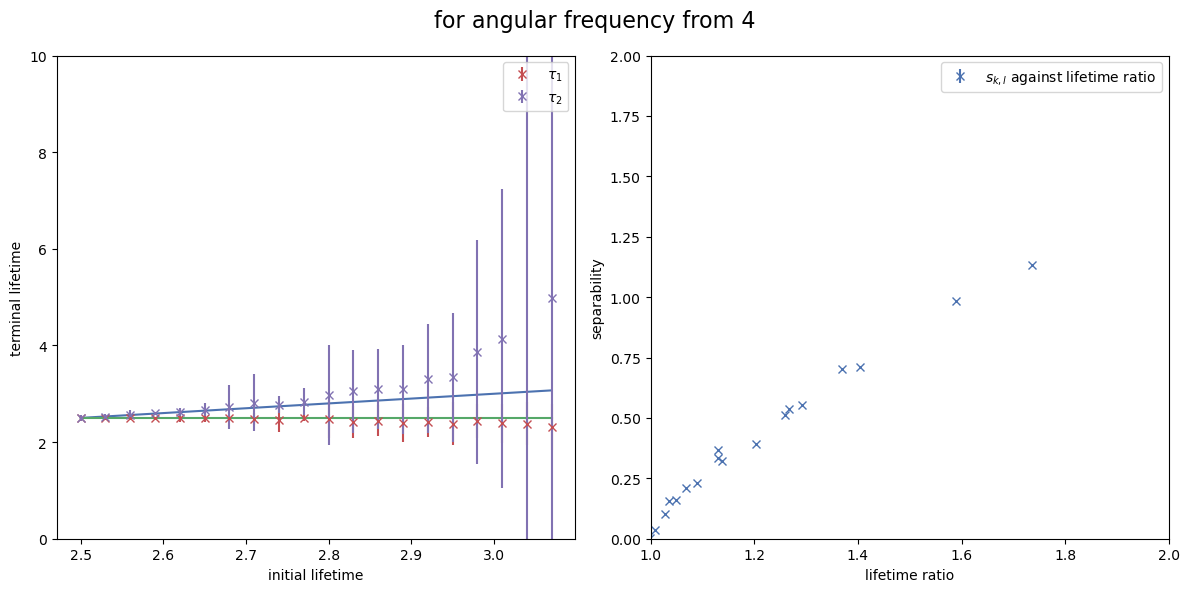

separability_kl is  1.1297989037890983 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 18th data. 
Thus, the critical lifetime ratio is 1.7634380569086479


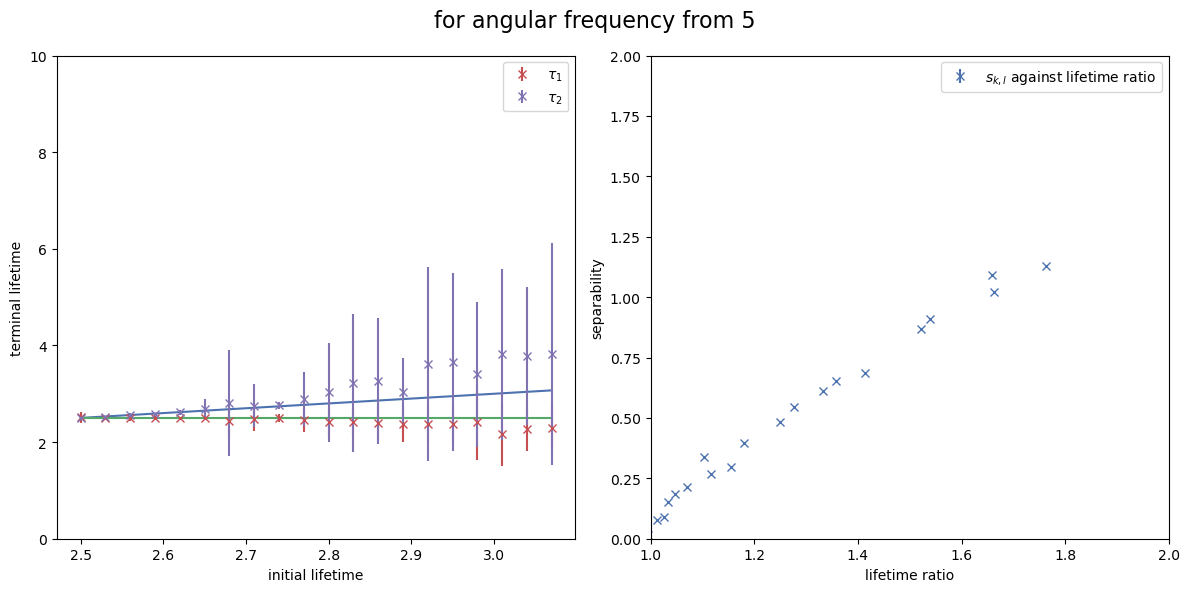

separability_kl is  1.1087359007708049 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 17th data. 
Thus, the critical lifetime ratio is 1.9828890069977454


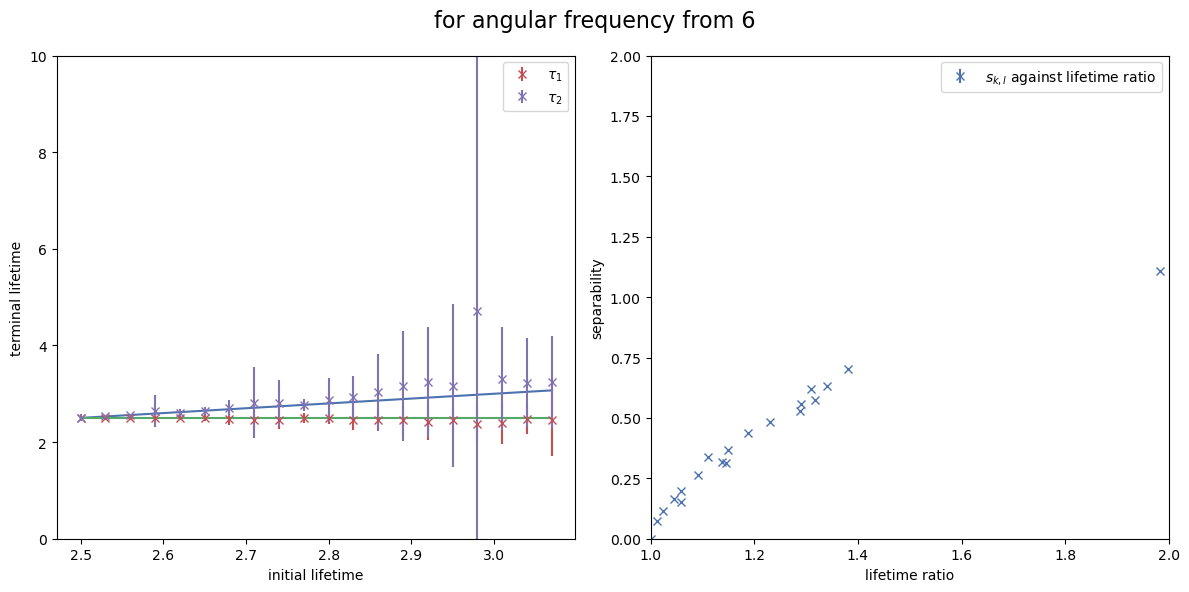

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1355287296.py:36: RuntimeWarning: invalid value encountered in divide
  separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5


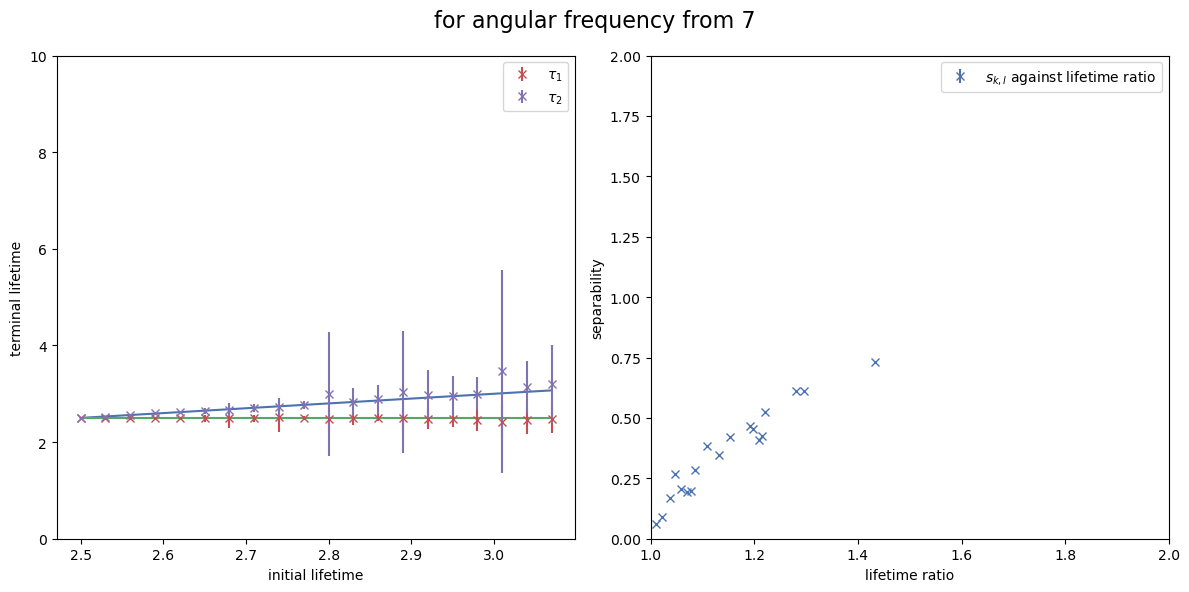

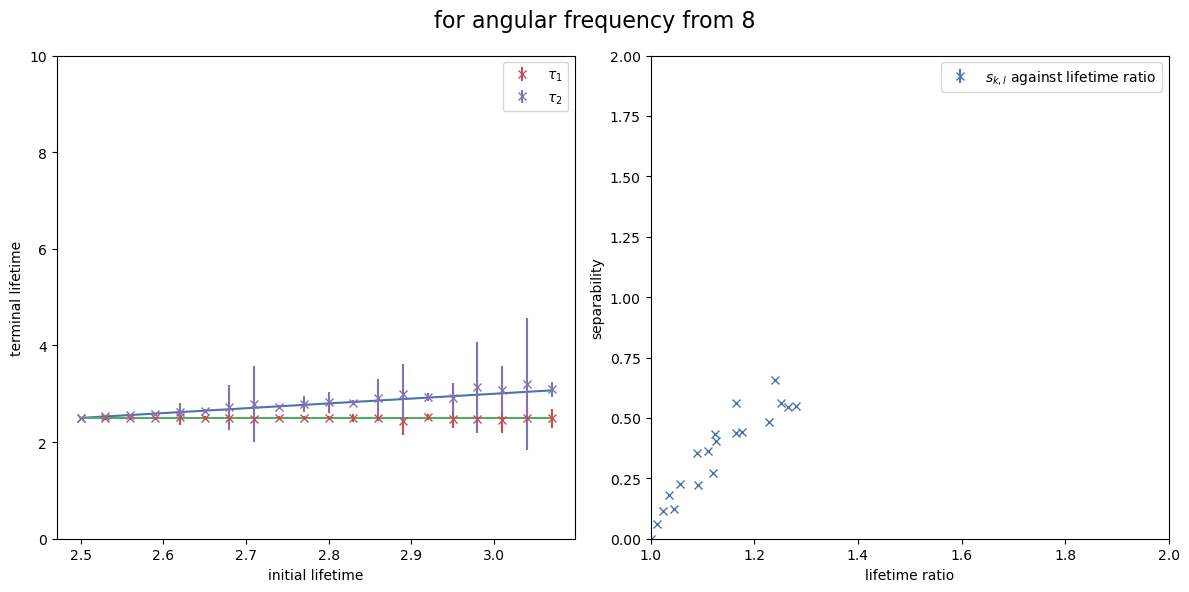

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


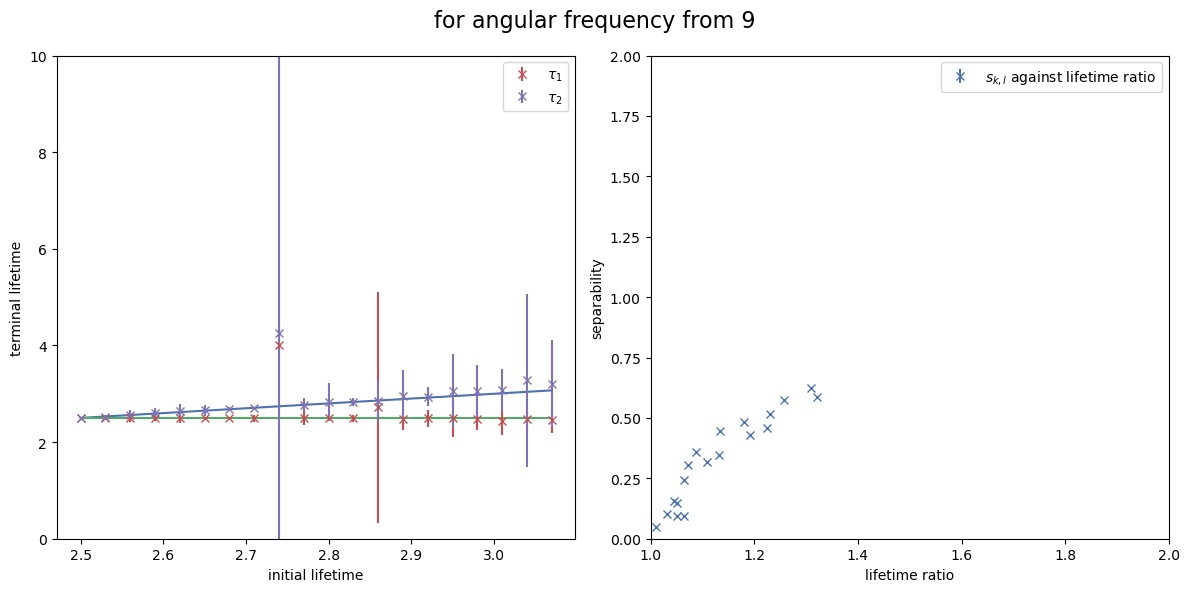

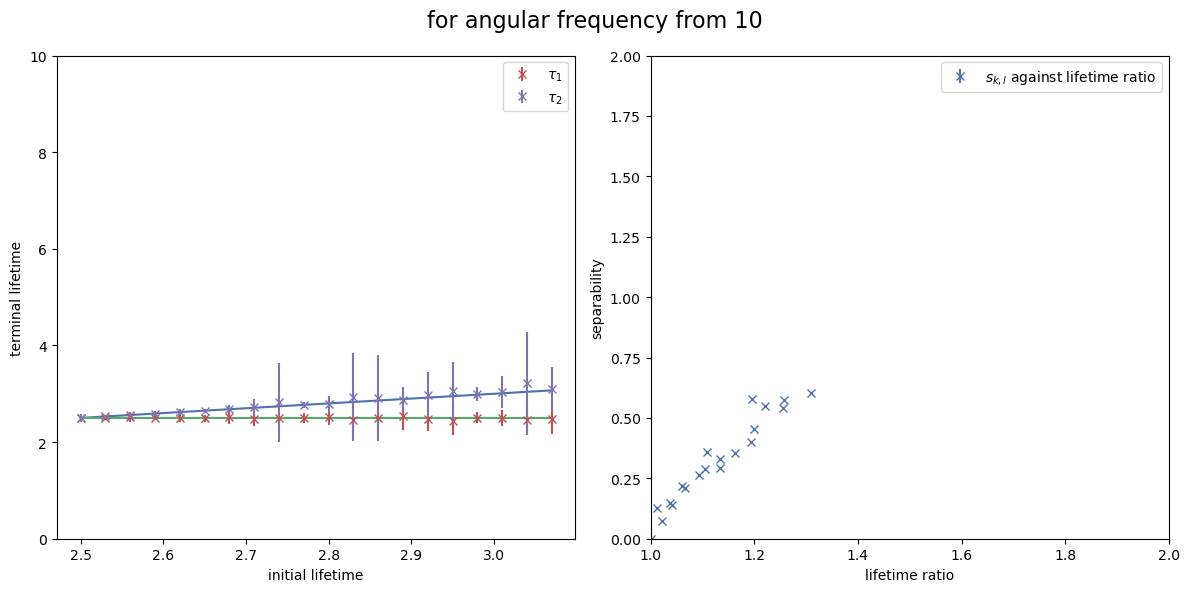

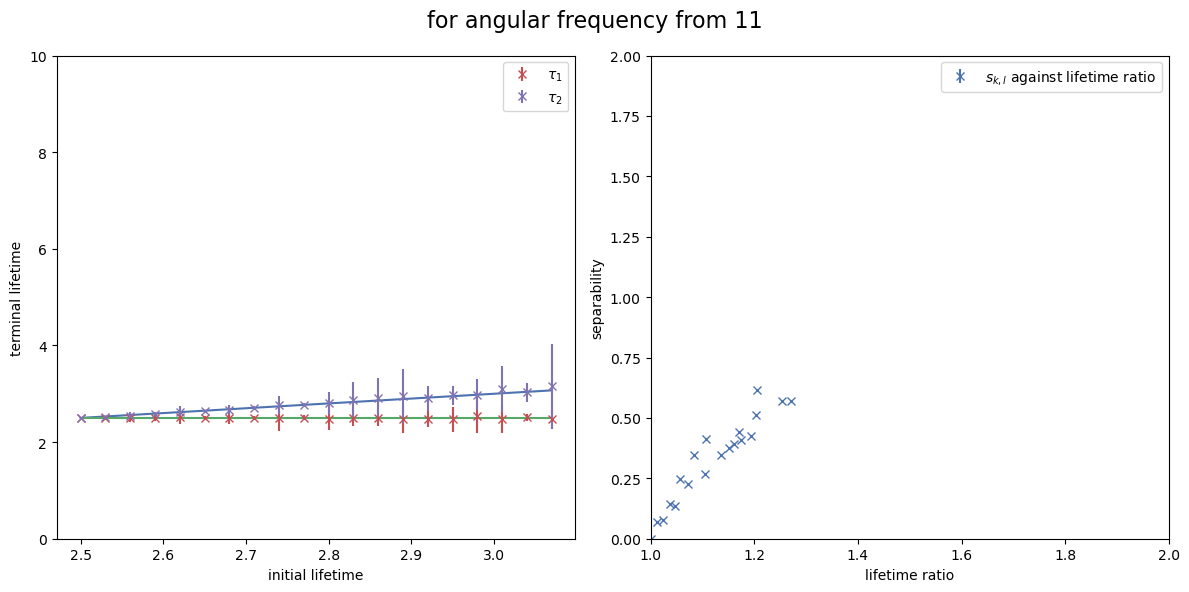

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


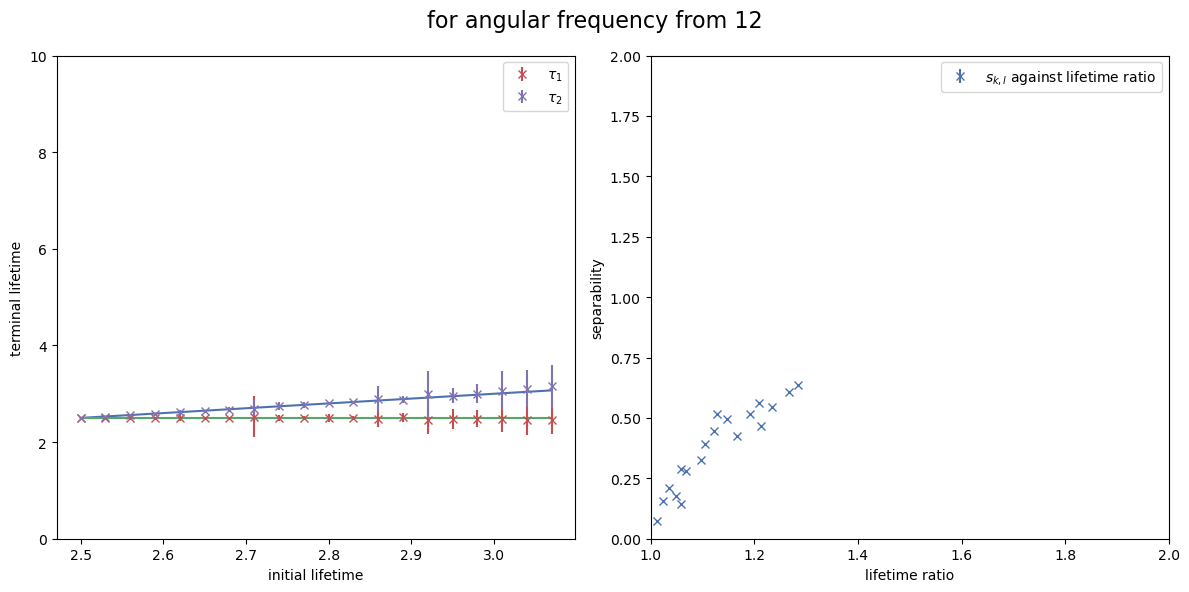

separability_kl is  nan , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 1th data. 
Thus, the critical lifetime ratio is 1.0


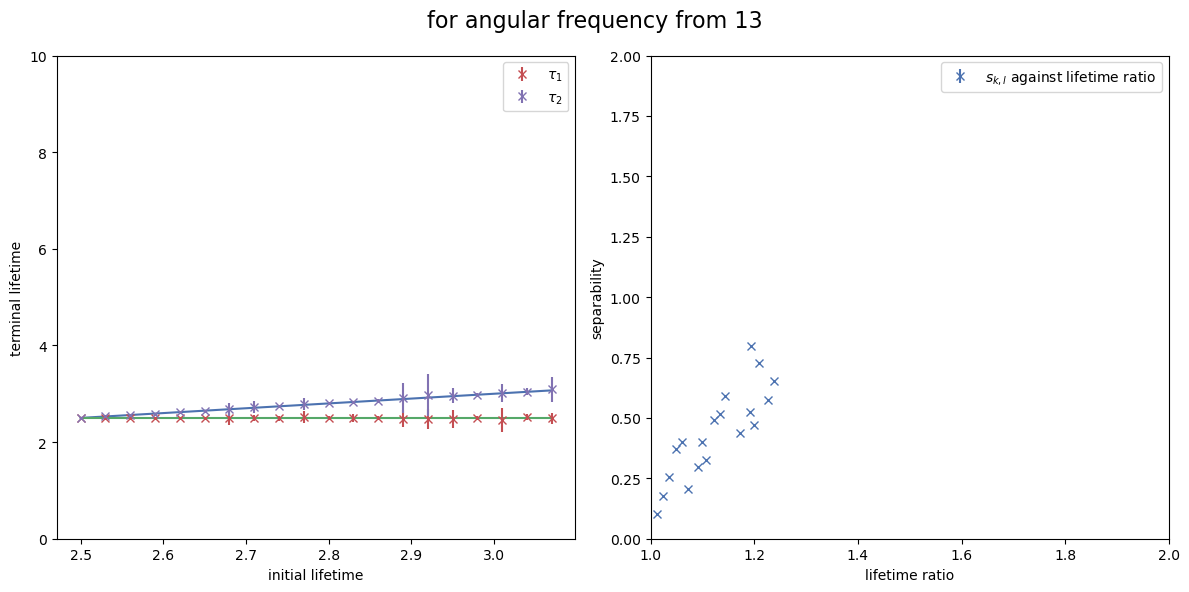

separability_kl is  292.25954058307764 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 3th data. 
Thus, the critical lifetime ratio is 1.0240000000000007


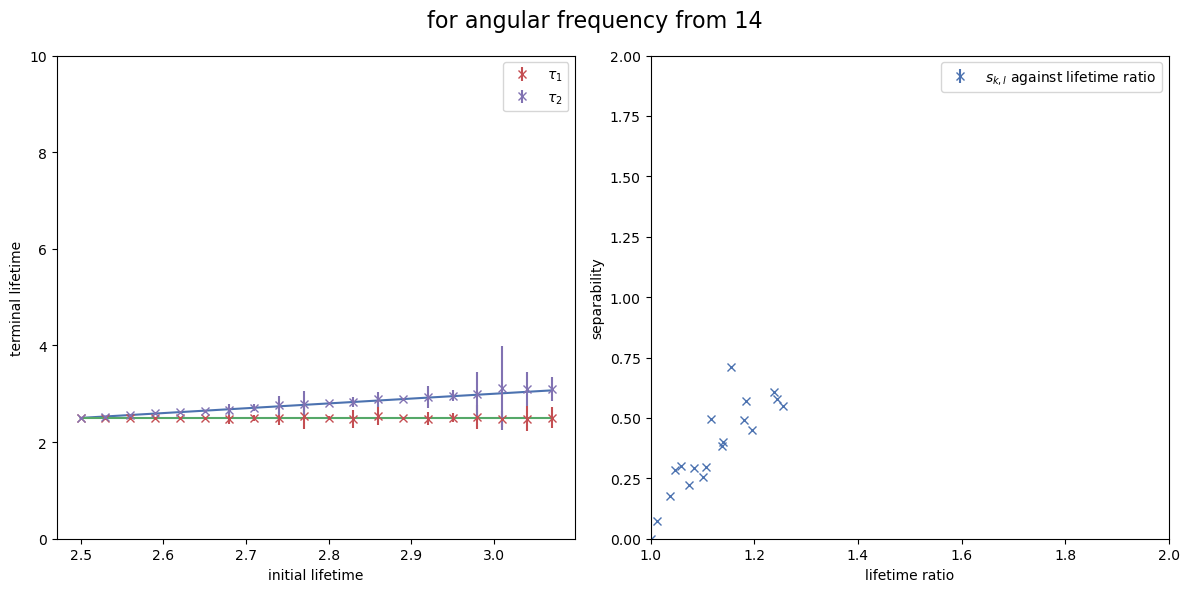

separability_kl is  173.7785625444099 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 2th data. 
Thus, the critical lifetime ratio is 1.0120000000000002


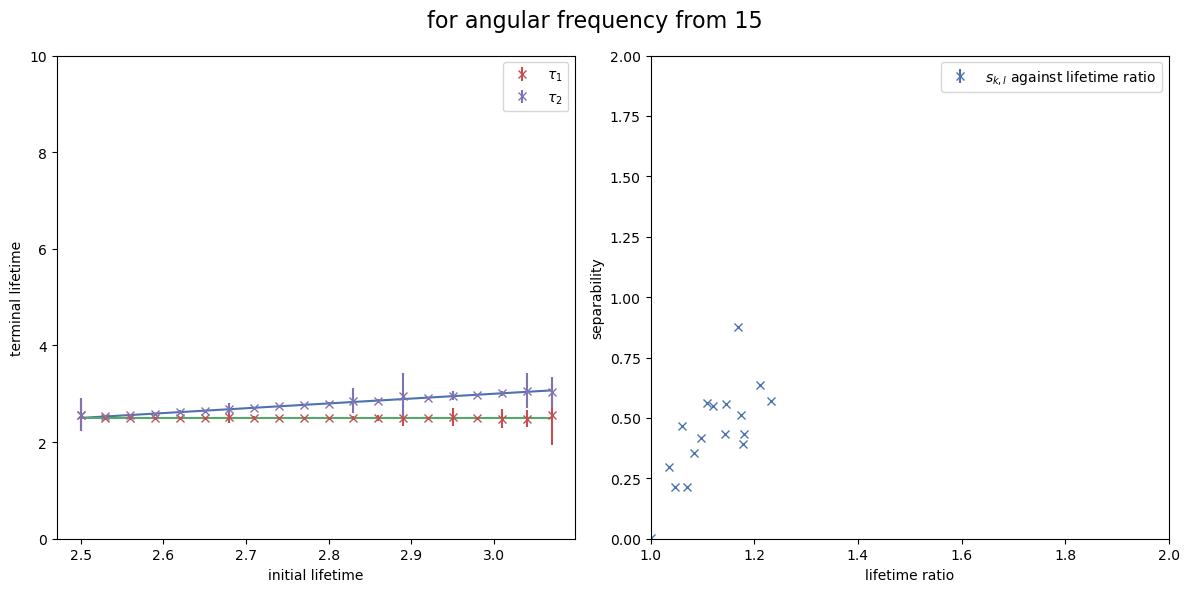

separability_kl is  292.25954058307764 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 3th data. 
Thus, the critical lifetime ratio is 1.0240000000000007


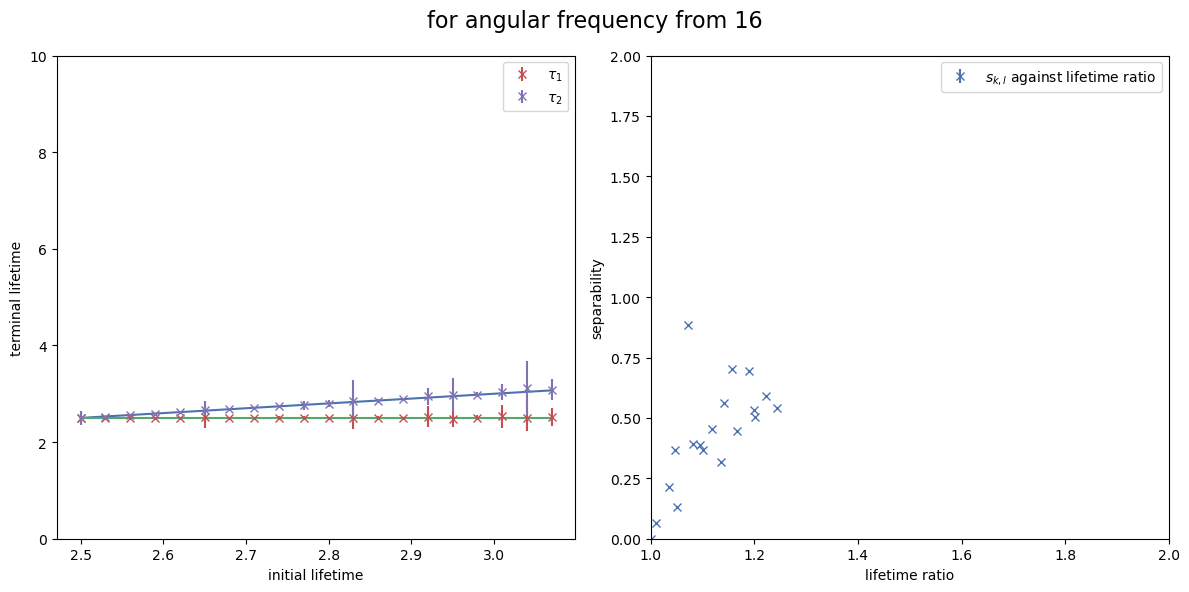

separability_kl is  173.7785625444099 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 2th data. 
Thus, the critical lifetime ratio is 1.0120000000000002


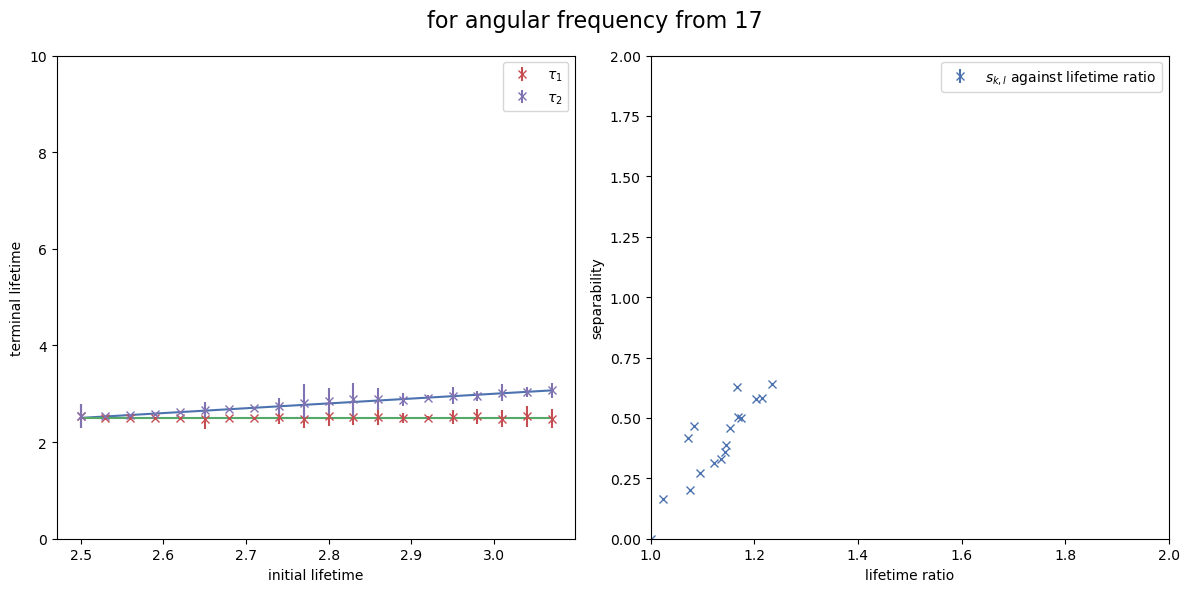

separability_kl is  414.60301223635014 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 4th data. 
Thus, the critical lifetime ratio is 1.036000000000001


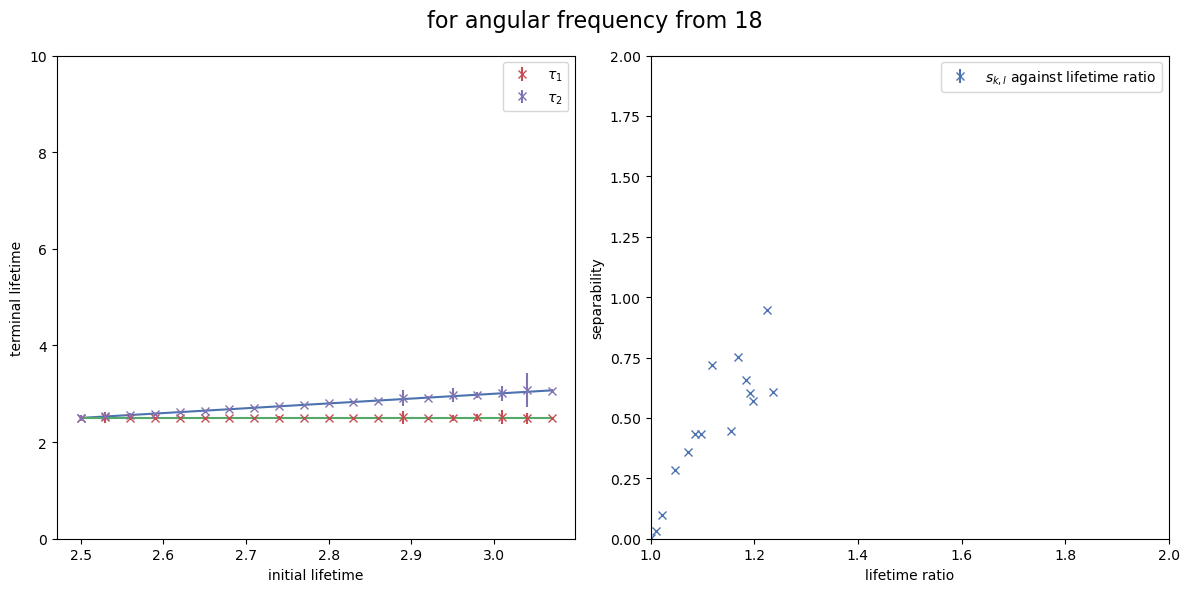

separability_kl is  173.7785625444099 , it's first nonseparatable pair of liftimes.
The lifetimes are separable from the 2th data. 
Thus, the critical lifetime ratio is 1.0120000000000002


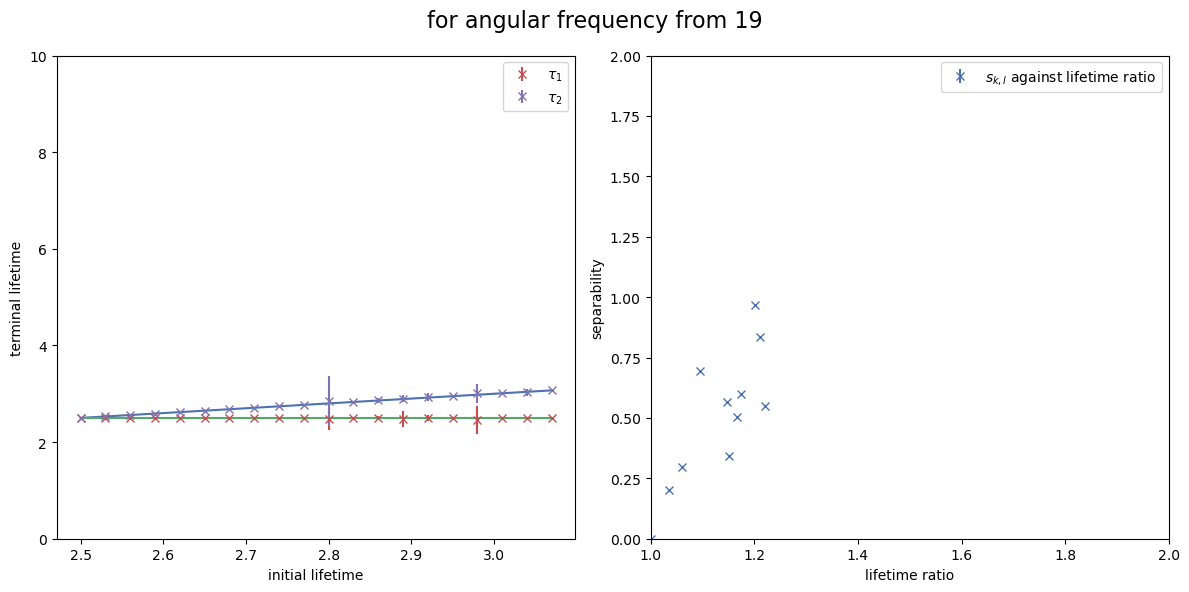

In [30]:
# simulation for different lifetimes
INDEX_array = range(20)
for INDEX_i in INDEX_array:
    tau_array = np.linspace(2.5,3.07,20)
    par_arr = np.zeros((20,100,3))
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau])
    INDEX_arr[INDEX_i], separation_arr[INDEX_i], critical_tau_arr[INDEX_i] = plot_w(par_arr)

The critical lifetime ratio would be  1.0314576460674225  for varying angular frequency.


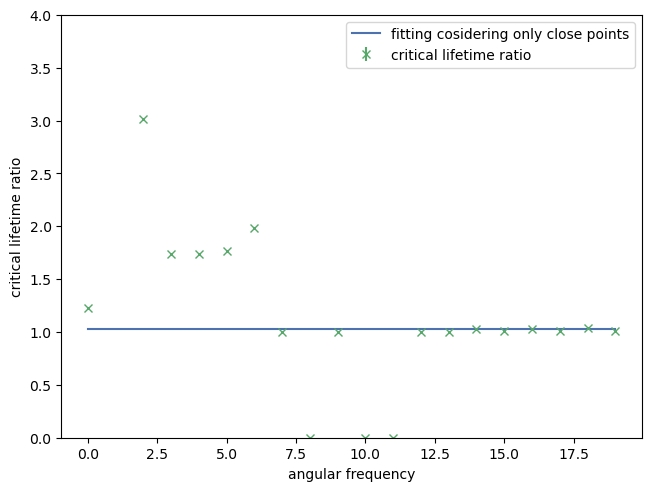

In [31]:
initial_guess = 1.05
selected = (critical_tau_arr > (initial_guess - 0.5)) & (critical_tau_arr < (initial_guess + 0.5))
fitted_critical_tau_arr = np.mean(critical_tau_arr[selected])
print("The critical lifetime ratio would be ",fitted_critical_tau_arr, " for varying angular frequency.")

plt.figure()
plt.ylim(0,4)
plt.plot([0,19],[fitted_critical_tau_arr,fitted_critical_tau_arr],label='fitting cosidering only close points')
plt.errorbar(INDEX_arr, critical_tau_arr, yerr=0, fmt='x', label="critical lifetime ratio")
plt.xlabel("angular frequency")
plt.ylabel("critical lifetime ratio")
plt.legend()
plt.show()

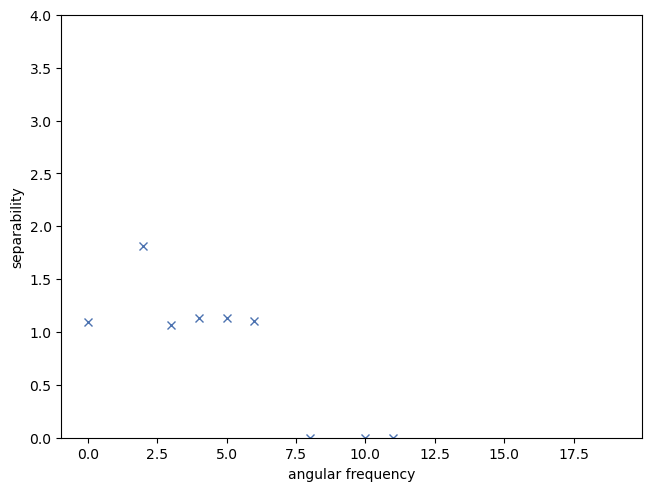

In [36]:
initial_guess = 1.5
#selected = (critical_tau_arr > (initial_guess - 0.5)) & (critical_tau_arr < (initial_guess + 0.5))
fitted_critical_tau_arr = np.mean(critical_tau_arr[selected])

plt.figure()
plt.ylim(0,4)
#plt.plot([0,19],[fitted_critical_tau_arr,fitted_critical_tau_arr],label='fitting cosidering only close points')
plt.errorbar(INDEX_arr, separation_arr, yerr=0, fmt='x')
plt.xlabel("angular frequency")
plt.ylabel("separability")
plt.show()

## Replot

In [253]:
def plot_sep(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    plt.errorbar(tau_array, separability_kl, yerr=0, fmt='x', label=f"{sec_i+1}", color=colors[sec_i])
    return 

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: divide by zero encountered in divide
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-

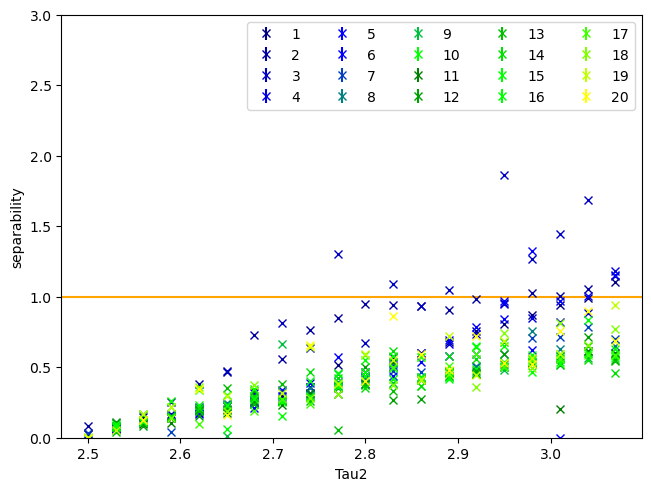

In [256]:
plt.figure()
plt.xlabel("Tau2")
plt.ylabel("separability")
plt.ylim(0,3)

tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for sec_i in range(20):
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau],sec_i)
    plot_sep(par_arr,sec_i)
plt.axhline(y=1, color='orange', linestyle='-')
plt.legend(ncol=5)
plt.show()

In [286]:
def plot_ratio(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    tau_ratio = mean[:,2]/mean[:,1]
    critical_tau_ratio = 0
    ha = 0
    for sep_i in range(20):
        if separability_kl[sep_i] >= 1 and ha == 0: 
            critical_tau_ratio = tau_ratio[sep_i]
            ha += 1
        else:
            pass
    plt.errorbar(sec_i, critical_tau_ratio, yerr=0, fmt='x', label=f"{sec_i}")
    return

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\266098766.py:14: RuntimeWarning: invalid value encountered in divide
  separability_kl = abs(mean[:,1]-mean[:,2]) /

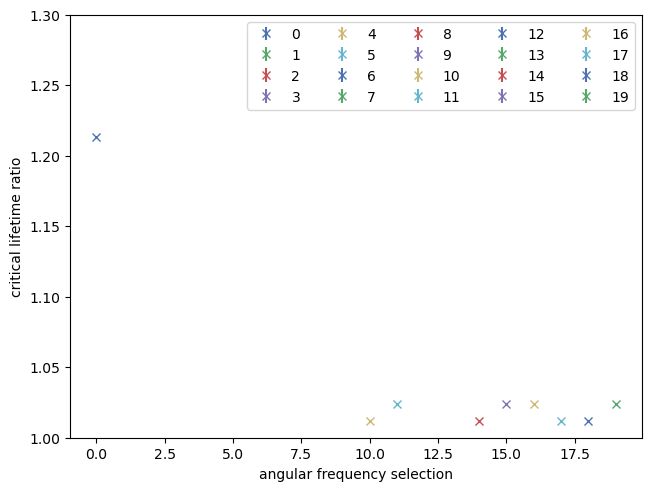

In [287]:
plt.figure()
plt.xlabel("angular frequency selection")
plt.ylabel("critical lifetime ratio")
plt.ylim(1,1.3)

tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for sec_i in range(20):
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau],sec_i)
    plot_ratio(par_arr,sec_i)
#plt.axhline(y=1, linestyle='-',color='orange')
plt.legend(ncol=5)
plt.show()

In [ ]:
plt.figure()
plt.xlabel("angular frequency selection")
plt.ylabel("critical lifetime ratio")
plt.ylim(1,3)

tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for sec_i in range(20):
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau],sec_i)
    plot_ratio(par_arr,sec_i)
#plt.axhline(y=1, linestyle='-',color='orange')
plt.legend(ncol=5)
plt.show()

In [325]:
def plot_s_ratio(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    tau_ratio = mean[:,2]/mean[:,1]
    plt.errorbar(tau_ratio, separability_kl, yerr=0, fmt='x', label=f"{sec_i}", color=colors[sec_i])
    return

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in exp
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:11: RuntimeWarning: overflow encountered in multiply
  y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\758509795.py:14: RuntimeWarning: invalid value encountered in divide
  separability_kl = abs(mean[:,1]-mean[:,2]) /

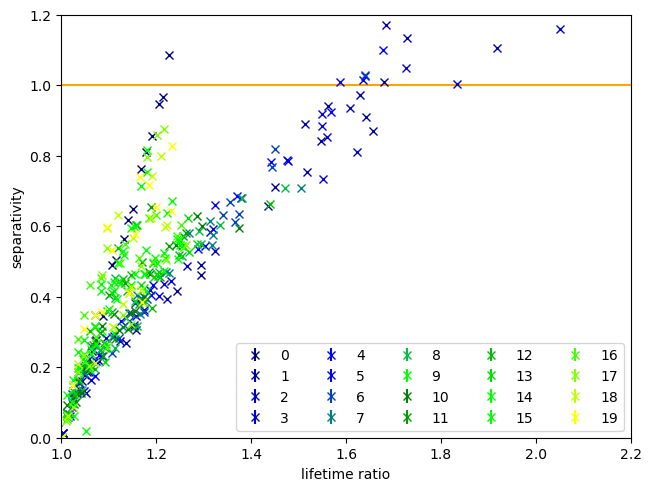

In [326]:
plt.figure()
plt.xlabel("lifetime ratio")
plt.ylabel("separativity")
plt.xlim(1,2.2)
plt.ylim(0,1.2)

tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
for sec_i in range(20):
    for i in range(len(tau_array)):
        tau2 = tau_array[i]
        EGFP = Phasor([0.497,0.503],[2.5,tau2])
        for j in range(len(EGFP.phasor_data)): #no background
            phasor = EGFP.phasor_data[j]
            par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau],sec_i)
    plot_s_ratio(par_arr,sec_i)
plt.axhline(y=1, linestyle='-',color='orange')
plt.legend(ncol=5)
plt.show()

## Discuss behavior if using analytic phasor

In [206]:
# use analytic phasor: assign multi_exp_FT to phasor_test 
# multi_exp_FT(omega,A,tau,n) gives solve for A_tau_arr such that it gives 0

In [272]:
def multi_exp_FT_ana(omega,A,tau):
    '''Analytic solution to Fourier Transform (normalized, i.e. divided by int_0^infty exp(-t/tau)dt) 
    of multi exponential decay with components lifetime tau
    Input:
    omega     angular frequency array
    A         amplitude array
    tau       lifetime'''
    coeff = A*tau/np.sum(A*tau) #coefficient of the sum of mono_exp_FT
    mono_arr = exp_FT(omega,tau)#array of FT of each lifetime
    return np.dot(coeff,mono_arr)

def phasor_eq_func_ana(A_tau_arr,phasor):
    '''Function to be passed to phasor_solve_num to solve for A_tau array (A1, tau1, tau2) (2n-1)
       Input: 
       A_tau_arr    parameter array A1 tau1, tau2
       phasor       phasor array from Simulation().phasor to be resolved '''
    n = int((len(A_tau_arr)+1)/2) #number of components
    A_tau_arr = np.insert(A_tau_arr,n-1,1-np.sum(A_tau_arr[:n-1])) #insert An
    y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n)]) #pure multiexponential
    # y  += (1-np.sum(A_tau_arr[:n-1]))*np.exp(-EGFP.t / A_tau_arr[-1]) #last component
    y  = np.convolve(y,EGFP.ker,'full')[:EGFP.n_bins]/np.sum(EGFP.ker)
    w,phasor_test = EGFP.phasor_fft(y=y) 
    phasor_test = multi_exp_FT(w,A_tau_arr[0:n],A_tau_arr[n:,]) 
    return phasor_test.real[0:2*n-1] #solve for A_tau_arr such that it gives 0
    
def phasor_solve_num_ana(phasor,x0):
    '''Solve for amplitude and lifetimes numerically using 3 phasors for 3 parameters (A1, tau1, tau2)
       phasor      phasor array (Simulation().phasor) to be resolved
       x0          initial guess for a_tau_arr'''
    return fsolve(phasor_eq_func_ana,x0=x0,args = phasor)

In [321]:
def plot_s_ratio_ana(x,sec_i):
    '''
    calculate the paras and plot the graph for different angular frequency
    input:
    x     par_arr
    output:
    INDEX_i                    angular frequency selection
    separability_kl[s_min]     separability
    critical_tau_ratio         critical lifetime ratio
    '''
    # calculate means and standard deviations
    mean = np.mean(x,axis = 1)
    std = np.std(x,axis = 1)
    separability_kl = abs(mean[:,1]-mean[:,2]) / (np.sqrt(std[:,1])+np.sqrt(std[:,2]))**0.5
    tau_ratio = mean[:,2]/mean[:,1]
    slope, intercept = np.polyfit(tau_ratio, separability_kl, 1)
    def g(tau_ratio):
        y_fit = slope * tau_ratio + intercept
        return y_fit
    def find_x_for_y_equals_1(tau_ratio):
        return g(tau_ratio) - 1
    x_inter = fsolve(find_x_for_y_equals_1, x0=1)
    print(sec_i+1,x_inter[0])
    
    plt.plot(tau_ratio, g(tau_ratio),color=colors[sec_i])
    plt.errorbar(tau_ratio, separability_kl, yerr=0, fmt='x', label=f"{sec_i}", color=colors[sec_i])
    return

C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
C:\Users\xujia\AppData\Local\Temp\ipykernel_2352\1255625879.py:10: RuntimeWarning: overflow encountered in multiply
  y  = sum([A_tau_arr[j] * np.exp(-EGFP.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential


1 1.2195734075764233


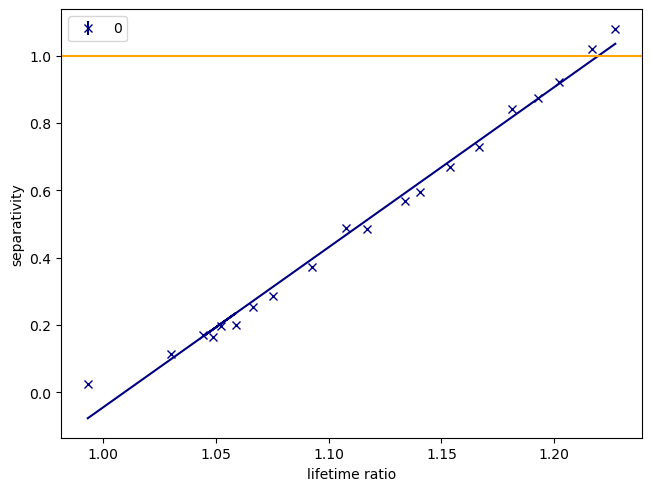

In [322]:
plt.figure()
plt.xlabel("lifetime ratio")
plt.ylabel("separativity")
#plt.ylim(1,1.3)

tau_array = np.linspace(2.5,3.07,20)
par_arr = np.zeros((20,100,3))
sec_i = 0
for i in range(len(tau_array)):
    tau2 = tau_array[i]
    EGFP = Phasor([0.497,0.503],[2.5,tau2])
    for j in range(len(EGFP.phasor_data)): #no background
        phasor = EGFP.phasor_data[j]
        par_arr[i,j] = phasor_solve_num_w(phasor,[EGFP.amp[0],*EGFP.tau],sec_i)
plot_s_ratio_ana(par_arr,0)
plt.axhline(y=1, color='orange', linestyle='-')
plt.legend(ncol=5)
plt.show()